In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
pip install tensorflow==2.18.0 --upgrade

Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tens

In [41]:
# =========================
# 1️⃣ Imports & Paths
# =========================
import os
import cv2
import numpy as np
from tqdm import tqdm
import pywt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Image folders (replace with your actual paths)
DATASET_A = "/kaggle/input/official_scanner"
DATASET_B = "/kaggle/input/wickey_pieda"
DATASET_C = "/kaggle/input/rezogiial_images"

IMG_SIZE = (256, 256)
DENOISE_METHOD = "wavelet"

In [ ]:
# =========================
# 2️⃣ Preprocessing functions
# =========================
def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img

def resize_to(img, size=IMG_SIZE):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def normalize_img(img):
    return img.astype(np.float32) / 255.0

def denoise_wavelet_img(img):
    coeffs = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs
    cH[:] = 0; cV[:] = 0; cD[:] = 0
    return pywt.idwt2((cA, (cH, cV, cD)), 'haar')

def preprocess_image(fpath):
    img = cv2.imread(fpath, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"⚠️ Skipping unreadable image: {fpath}")
        return None
    img = to_gray(img)
    img = resize_to(img)
    img = normalize_img(img)
    den = denoise_wavelet_img(img)
    residual = img - den
    return residual.astype(np.float32)

In [1]:

import os
import cv2
import numpy as np
from scipy.ndimage import median_filter

# ----------- DATASET PATHS -----------
DATASET1 = "/kaggle/input/tracer/dataset-trace/dataset-trace"
DATASET2 = "/kaggle/input/tracer/dataset-trace-2/dataset-trace-2"
DATASET3 = "/kaggle/input/tracer/dataval-trace/dataval-trace"
# -------------------------------------

IMG_SIZE = 128
X = []
y = []

def load_dataset(DATASET_PATH):
    print("\n📁 Loading:", DATASET_PATH)

    for root, dirs, files in os.walk(DATASET_PATH):

        label = os.path.basename(os.path.dirname(root)) # last folder name = label

        for file in files:

            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):

                img_path = os.path.join(root, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is None:
                    print("⚠️ Error loading:", img_path)
                    continue

                # Resize
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                # Denoise
                img = median_filter(img, size=3)

                # Normalize
                img = img.astype(np.float32) / 255.0

                # Add channel dimension
                img = np.expand_dims(img, axis=-1)

                X.append(img)
                y.append(label)

    print("✔ Completed:", DATASET_PATH)


# -------- LOAD ALL 3 DATASETS --------
load_dataset(DATASET1)
load_dataset(DATASET2)
load_dataset(DATASET3)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("\n==============================")
print("✔ TOTAL IMAGES:", X.shape)
print("✔ TOTAL LABELS:", len(y))
print("✔ UNIQUE CLASSES:", np.unique(y))
print("==============================")



📁 Loading: /kaggle/input/tracer/dataset-trace/dataset-trace
✔ Completed: /kaggle/input/tracer/dataset-trace/dataset-trace

📁 Loading: /kaggle/input/tracer/dataset-trace-2/dataset-trace-2
✔ Completed: /kaggle/input/tracer/dataset-trace-2/dataset-trace-2

📁 Loading: /kaggle/input/tracer/dataval-trace/dataval-trace
✔ Completed: /kaggle/input/tracer/dataval-trace/dataval-trace

✔ TOTAL IMAGES: (4568, 128, 128, 1)
✔ TOTAL LABELS: 4568
✔ UNIQUE CLASSES: ['Canon120-1' 'Canon120-2' 'Canon220' 'Canon9000-1' 'Canon9000-2'
 'EpsonV370-1' 'EpsonV370-2' 'EpsonV39-1' 'EpsonV39-2' 'EpsonV550' 'HP']


In [2]:
# Label Encoding + Train/Test Split + tf.data 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to categorical
num_classes = len(np.unique(y_encoded))
y_cat = to_categorical(y_encoded, num_classes)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_encoded
)



#
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

# tf.data pipelines
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(buffer_size=len(X_train)) \
    .batch(BATCH) \
    .prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .batch(BATCH) \
    .prefetch(AUTOTUNE)

print("Train:", X_train.shape)
print("Test :", X_test.shape)
print("Classes:", num_classes, le.classes_)


2025-12-04 09:38:23.065873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764841103.493472      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764841103.633204      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

I0000 00:00:1764841128.868490      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764841128.869261      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Train: (3654, 128, 128, 1)
Test : (914, 128, 128, 1)
Classes: 11 ['Canon120-1' 'Canon120-2' 'Canon220' 'Canon9000-1' 'Canon9000-2'
 'EpsonV370-1' 'EpsonV370-2' 'EpsonV39-1' 'EpsonV39-2' 'EpsonV550' 'HP']


In [4]:
# Build Hybrid CNN (Image-Only Hybrid)

# ➡️ Hybrid idea:
# CNN features + Global noise features (average pooling + max pooling) → fused.


import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SHAPE = (128, 128, 1)

# Image Input
img_in = layers.Input(shape=IMG_SHAPE, name="image_input")

# CNN Branch
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(img_in)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
cnn_feat = layers.GlobalAveragePooling2D()(x)

# Global Noise Branch (Hybrid Part)
g1 = layers.GlobalAveragePooling2D()(img_in)
g2 = layers.GlobalMaxPooling2D()(img_in)

# Merge both CNN + noise features
merged = layers.Concatenate()([cnn_feat, g1, g2])

dense = layers.Dense(128, activation='relu')(merged)
dense = layers.Dropout(0.3)(dense)

out = layers.Dense(num_classes, activation='softmax')(dense)

model = models.Model(inputs=img_in, outputs=out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_5[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1)         │          0 │ image_input[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1)         │          0 │ image_input[0][0] │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 130)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,768 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 11)        │      1,419 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,859 (433.04 KB)

 Trainable params: 110,859 (433.04 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train Model (With Callbacks)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "hybrid_cnn_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True
)


from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_encoded),
    y=y_encoded
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[checkpoint, early],
    class_weight=class_weights
)


#

Class Weights: {0: 0.9982517482517482, 1: 0.9982517482517482, 2: 0.9982517482517482, 3: 0.9982517482517482, 4: 1.0203261112352022, 5: 0.9982517482517482, 6: 0.9958578591672117, 7: 0.9982517482517482, 8: 0.9982517482517482, 9: 0.9982517482517482, 10: 0.9982517482517482}
Epoch 1/50


I0000 00:00:1764841273.227528     116 service.cc:148] XLA service 0x7d67a00072b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764841273.229469     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764841273.229495     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764841273.672732     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


 13/115 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1135 - loss: 2.4111

I0000 00:00:1764841278.018765     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0926 - loss: 2.4080
Epoch 1: val_accuracy improved from -inf to 0.09081, saving model to hybrid_cnn_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.0925 - loss: 2.4080 - val_accuracy: 0.0908 - val_loss: 2.3985
Epoch 2/50
113/115 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0966 - loss: 2.4018
Epoch 2: val_accuracy improved from 0.09081 to 0.09847, saving model to hybrid_cnn_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0966 - loss: 2.4017 - val_accuracy: 0.0985 - val_loss: 2.3983
Epoch 3/50
113/115 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0850 - loss: 2.4000
Epoch 3: val_accuracy did not improve from 0.09847
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0851 - loss: 2.4000 - val_accuracy: 0.0908 - val_loss: 2.3980
Epoch 4/50
113/115 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0926 - loss: 2.4002
Epoch 4: val_accuracy did not improve from 0.09847
115/115 ━━━━━━━━━━━

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Accuracy: 0.3293216630196937

Classification Report:
              precision    recall  f1-score   support

  Canon120-1       0.20      0.05      0.08        83
  Canon120-2       0.18      0.02      0.04        83
    Canon220       0.16      0.98      0.27        83
 Canon9000-1       0.42      0.80      0.55        83
 Canon9000-2       0.00      0.00      0.00        82
 EpsonV370-1       0.85      0.80      0.82        83
 EpsonV370-2       0.64      0.08      0.15        84
  EpsonV39-1       0.00      0.00      0.00        83
  EpsonV39-2       0.00      0.00      0.00        84
   EpsonV550       0.00      0.00      0.00        83
          HP       0.60      0.90      0.72        83

    accuracy                           0.33       914
   macro avg       0.28      0.33      0.24       914
weighted avg       0.28      0.33      0.24       914



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


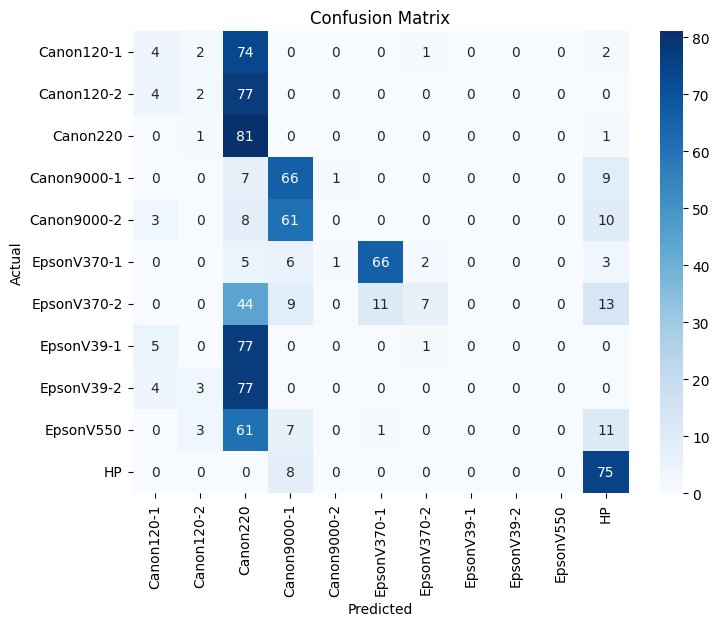

In [6]:
# Accuracy + Confusion Matrix + Classification Report


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
acc = np.mean(y_pred_labels == y_true)
print("Accuracy:", acc)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [8]:
# मॉडल को .keras फॉर्मैट में सेव करें
model.save("hybrid_cnn_model.keras")


In [9]:
import pickle
from tensorflow.keras.models import load_model

# .keras फॉर्मैट से मॉडल लोड करें
model = load_model("hybrid_cnn_model.keras")

# अब मॉडल को pickle में सेव करें
with open("hybrid_cnn_model.pkl", "wb") as f:
    pickle.dump(model, f)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
